# __Data imputation__

### __Have we got what we think we have got?__

According to the source of our data of CO2 emissions, they were to be dispatched every 5 mins. However, can we really be sure that that's the case over a period of about 10 years? We will find that out over the next couple of cells.

In [85]:
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
file_path = '../../big_data/df_DUID_price_range.pkl'
df = pd.read_pickle(file_path)

df.tail()

,Price,CO2E_EMISSIONS_FACTOR
PeriodID,,
2019-08-01 03:35:00,84.78346,0.573436
2019-08-01 03:40:00,84.78689,0.573436
2019-08-01 03:45:00,85.14416,0.573436
2019-08-01 03:50:00,79.17710,0.456409
2019-08-01 03:55:00,79.52391,0.380340


In [75]:
def correct_timedelta(df, time_diff):
    '''
    df.index must be DateTimeIndex
    Returns two lists
    df=table_of_interest
    col="column_of_interest"
    time_diff=time_diff in seconds as int
    '''
    lst_1 = []
    lst_2 = []
    
    for i in range(1,df.shape[0]):
        delta = abs(df.index[i] - df.index[i-1])
        if int(delta.total_seconds()) != int(time_diff):
            lst_1.append((f'At time stamp {df.index[i-1]}, the interval is {int(delta.total_seconds()/60)} min or {round(float(delta.total_seconds()/3600),2)} h.'))
            lst_2.append((df.index[i-1], int(delta.total_seconds()/60)))
            
    return lst_1, lst_2


In [76]:
l1, l2 = correct_timedelta(df, 300)

In [83]:
l1[-5:]

['At time stamp 2018-06-01 03:55:00, the interval is 43205 min or 720.08 h.',
 'At time stamp 2018-08-18 11:45:00, the interval is 10 min or 0.17 h.',
 'At time stamp 2018-08-18 13:40:00, the interval is 10 min or 0.17 h.',
 'At time stamp 2018-09-14 10:50:00, the interval is 10 min or 0.17 h.',
 'At time stamp 2018-11-01 03:55:00, the interval is 43205 min or 720.08 h.']

## __Filling in the gaps__

### __DateTimeIndex__

Next, we will fill in the gaps of the DateTimeIndex. Note, that will leave us with NaN values in the remaining columns whereever datetimes are inserted into the index.

In [44]:
#hypothetical number of 5min intervals given the max and min values of the df time range

h = pd.date_range(start=df.index.min(), end=df.index.max(), freq="5min")
len(h)

1060704

In [45]:
assert abs(df.shape[0] - len(h)) < 0.000001

AssertionError: 

Here we clearly see that there is a mismatch between the hypothetical size of our time range if every 5 min interval was present and the size of our actual dataset.

__Filling in the DateTimeIndex:__

In [46]:
df = df.reindex(h)
print(df.shape)
df.head()

(1060704, 2)


,Price,CO2E_EMISSIONS_FACTOR
2009-07-01 04:00:00,1.35918,0.991217
2009-07-01 04:05:00,-0.00006,0.000000
2009-07-01 04:10:00,-0.00006,0.000000
2009-07-01 04:15:00,1.44014,0.991217
2009-07-01 04:20:00,1.75480,1.025701


In [47]:
df = df.sort_index(ascending=True)
df.isna().any()

Price                    True
CO2E_EMISSIONS_FACTOR    True
dtype: bool

Note that we have only filled in the DateTimeIndex so far. Any other columns were affected by the introduction of NaN values where datetimes have been filled in. In the next step we will impute the data into the other columns. Let's discuss how we best do it with a time series.

### __Imputation of CO2 and price__

Due to the nature of time series data, the imputation of missing values needs extra attention. The potential presence of time series trends and seasonality renders imputations using e.g. mean or median deduced from the entire dataset little useful. Instead, any imputation should rather consider the local value range around a NaN value. In the following, we will see one approach of how that works.

<img src="../images/time_series_imputation.jpg"> <br/>
source: https://www.hindawi.com/journals/mpe/2010/513810/fig9/

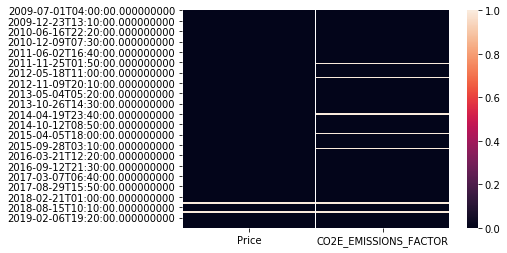

<Figure size 864x360 with 0 Axes>

In [53]:
fig = sns.heatmap(df.isnull())
plt.figure(figsize=(12,5));

Due to the nature of energy generator dispatch (see presentation), it makes sense to impute the date for the marginal CO2 emissions and price according to typical data imputations if time series (see above).

In [54]:
#we use the .rolling method to calculate the rolling mean composed of always 30 subsequent values
#the .assign method adds a new column with our rolling mean to df_new, all of which we save in df_impute

df_impute = df.assign(rolling_mean=df['CO2E_EMISSIONS_FACTOR'].rolling(window=30, min_periods=1).mean())

In [55]:
df_impute.head(50)

,Price,CO2E_EMISSIONS_FACTOR,rolling_mean
2009-07-01 04:00:00,1.35918,0.991217,0.991217
2009-07-01 04:05:00,-0.00006,0.000000,0.495609
2009-07-01 04:10:00,-0.00006,0.000000,0.330406
2009-07-01 04:15:00,1.44014,0.991217,0.495609
2009-07-01 04:20:00,1.75480,1.025701,0.601627
2009-07-01 04:25:00,7.61813,0.910143,0.653046
2009-07-01 04:30:00,7.64337,0.910143,0.689775
2009-07-01 04:35:00,8.58237,0.910143,0.717321
2009-07-01 04:40:00,8.00976,0.910143,0.738745
2009-07-01 04:45:00,7.45648,1.027702,0.767641


In [56]:
df_impute.isna().any()

Price                    True
CO2E_EMISSIONS_FACTOR    True
rolling_mean             True
dtype: bool

In [61]:
#here we use the numpy.where() method to replace only NaNs with values from the rolling_mean column
df_impute['CO2E_EMISSIONS_FACTOR'] = np.where(df_impute['CO2E_EMISSIONS_FACTOR'].isnull(),\
                                  df_impute['rolling_mean'], df_impute['CO2E_EMISSIONS_FACTOR'])

df_impute.drop(columns='rolling_mean', inplace=True)

In [62]:
#let's see if everything worked
df_impute.isna().any()

Price                    True
CO2E_EMISSIONS_FACTOR    True
dtype: bool

__Oh, there are still NaN values present there. Lets have a closer look at that:__

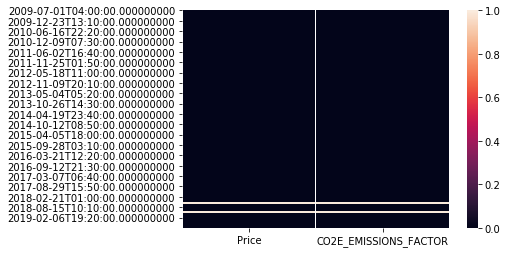

<Figure size 864x360 with 0 Axes>

In [66]:
fig = sns.heatmap(df_impute.isnull())
plt.figure(figsize=(12,5));

Notice above that our imputation only used 30 values to create a mean for imputation. These two gaps however comprise a whole month gap (see outcome of 'correct_timedelta above). Hence, they were not being filled. We will take care of that later.

Now we have preprocessed our dataset to a degree that we can start to look for relevant features to train a model to forecast the marginal CO2 emissions. Before we do that, it is mandatory for us to split the set into train and test sets right away:

In [90]:
#we have plenty of data; let's go and use a bit more than a year as our test and the remaing period as our training set
#NOTE: time series forecasts request that any training is done on data that lie in the past relative to the test data

train = df_impute[df_impute.index < dt.datetime(2018,6,1,0,0,0)]
test = df_impute[df_impute.index >= (dt.datetime(2018,6,1,0,0,0))]

For the training of a time series forecast it is necessary to train it with training data which lie in the relative past of the test data. Let's see if that holds true here. With the threshold chosen above, we do not have any NaN values in our train set and have to only consider it again when working with the testset.

In [91]:
print(train.index.min())
print(train.index.max())

print(test.index.min())
print(test.index.max())

2009-07-01 04:00:00
2018-05-31 23:55:00
2018-06-01 00:00:00
2019-08-01 03:55:00


In [92]:
assert train.index.max() < test.index.min()

In [97]:
train.CO2E_EMISSIONS_FACTOR.isna().any()

False

__We got rid of all the NaN values in our CO2 emissions column!__

In [93]:
train.to_pickle('../../data/train.pkl')
test.to_pickle('../../data/test.pkl')